In [2]:
from scripts.open_preprocess_racmo import *

Pathdata: /Volumes/imau01/rapid/RACMO2.3p2/FGRN055


# Intro
In order to use this script, one must have access to the server where the data is saved.

It is saved under "/Volumes/imau01/rapid/"

It can be accessed through finder, Go, Connect to server ... 

Make sure to be attached to the network cable at imau.

For some reason first the "!ls ... " needs to be called before jupyter can access data

In [3]:
!ls  "/Volumes/imau01/rapid/RACMO2.3p2/FGRN055"

BN_RACMO2.3p2_ERA5_3h_FGRN055 GIMP_DEM_90m
Downscaling_GR


In [90]:
ds = read_RACMO("5_5k", "Annual",years=["2000", "2020"], variable="runoff")




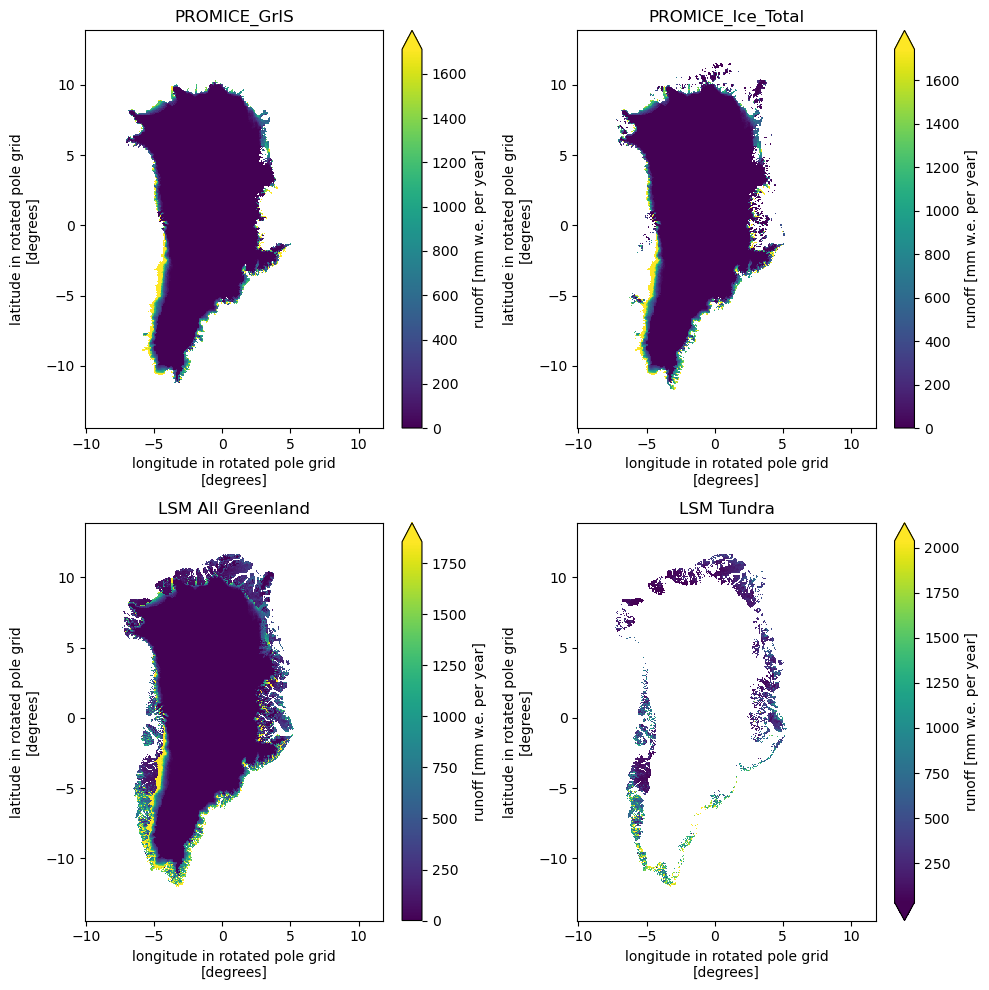

In [13]:
# make subplots for all masks 
masks = ["PROMICE_GrIS", "PROMICE_Ice_Total", "LSM All Greenland", "LSM Tundra"]

fig = plt.subplots(2,2, figsize=(10,10))
for i, mask in enumerate(masks):
    ds_masked = mask_data_5_5k(ds.isel(time=0), mask)
    ax = plt.subplot(2,2,i+1)
    ds_masked['runoff'].plot(ax=ax, robust=True)
    plt.title(mask)
plt.tight_layout()


# Per basin

In [14]:
import cmcrameri.cm as cmc
import matplotlib.colors as mcolors

In [15]:
# cmc.roma.colors
# get 8 colors from the roma colormap
colors = cmc.roma.colors
colors = [colors[i] for i in range(0, len(colors), len(colors)//8)]
colors_hex_Moug = [mcolors.rgb2hex(color) for color in colors]

dict_Moug_colors = dict(zip(np.arange(8), colors))


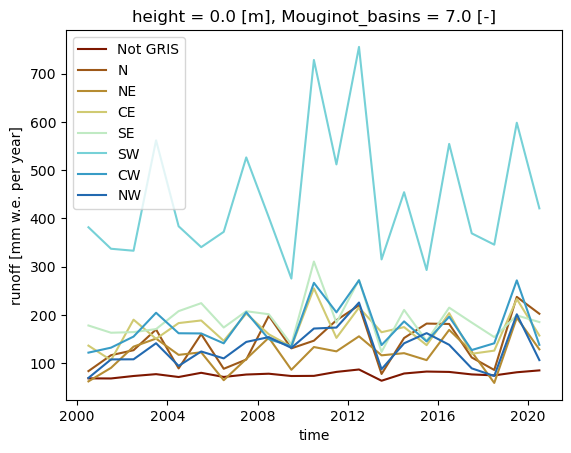

In [16]:
mask55 = open_mask_5_5k()
mask55['rlat'] = ds['rlat']
mask55['rlon'] = ds['rlon']
ds['Mouginot_basins'] = mask55['Mouginot_basins']

# for plotting mouginot basins, replace number 1 to 7 with N, NE, CE, SE, SW, CW, NW
dict_Moug = {0:"Not GRIS", 1: "N", 2: "NE", 3: "CE", 4: "SE", 5: "SW", 6: "CW", 7: "NW"}
    
dsMougTime = ds.squeeze().groupby('Mouginot_basins').mean().squeeze()['runoff']
for i, basin in enumerate(dsMougTime['Mouginot_basins']):
    dsMougTime.sel(Mouginot_basins=basin).plot.line(color=colors[i], label=dict_Moug[i])

# for legend replace numbers with dict
plt.legend()
# plt.figure()
# ds_vol = volume(ds['runoff'], "5_5k")
# ds_vol.sum(dim=['rlon', 'rlat']).plot()




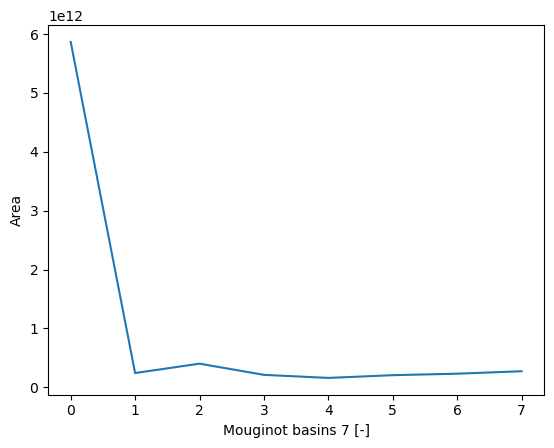

In [17]:
area55 = area(ds['runoff'], "5_5k")
area55["Moug_basins"] = mask55['Mouginot_basins']
area55.groupby('Moug_basins').sum().plot()

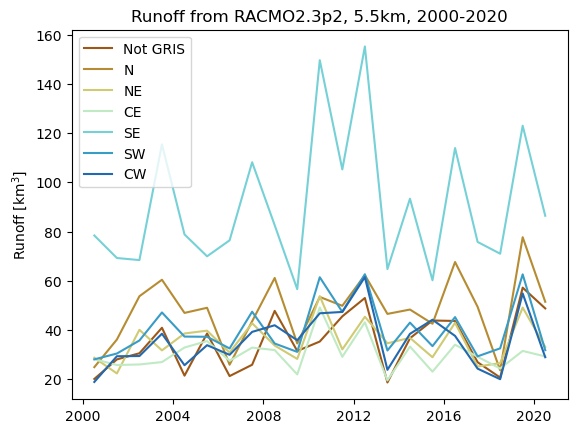

Text(0.5, 1.0, 'Mouginot basins, on top of LSM All Greenland mask')

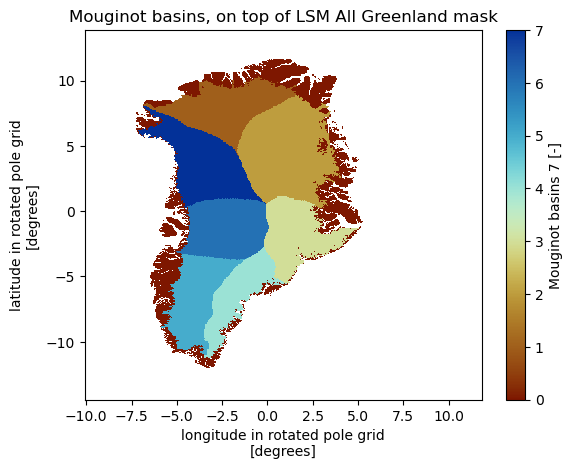

In [18]:
plt.figure()


ds5_vol  = volume(mask_data_5_5k(ds['runoff'], "LSM All Greenland",), '5_5k')
ds5_vol['Mouginot_basins'] = mask55['Mouginot_basins']
dsMougTime = ds5_vol.groupby('Mouginot_basins').sum().isel(height=0)
for i, basin in enumerate(dsMougTime['Mouginot_basins']):
    if i == 0:
       continue
    dsMougTime.sel(Mouginot_basins=basin).plot.line(color=colors[i], label=dict_Moug[i])

plt.ylabel(r"Runoff [km$^3$]")
plt.title("Runoff from RACMO2.3p2, 5.5km, 2000-2020")
plt.legend([dict_Moug[i] for i in range(0,8)], loc = 'upper left')
plt.xlabel("")

plt.show()

mask_data_5_5k(ds5_vol['Mouginot_basins'], "LSM All Greenland",).plot(cmap=cmc.roma)
plt.title("Mouginot basins, on top of LSM All Greenland mask")

## Per basin, including Tundra


In [111]:
path_mask_incl_Tundra = "/Volumes/imau01/rapid/RACMO2.3p2/FGRN055/BN_RACMO2.3p2_ERA5_3h_FGRN055/FGRN055_drainage_basins_all_land.nc"
mask_incl_Tundra = xr.open_dataset(path_mask_incl_Tundra)


/var/folders/cv/s_h5gzxd0h71t_d875wqxgzh0000gn/T/ipykernel_12414/3670806332.py:26: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


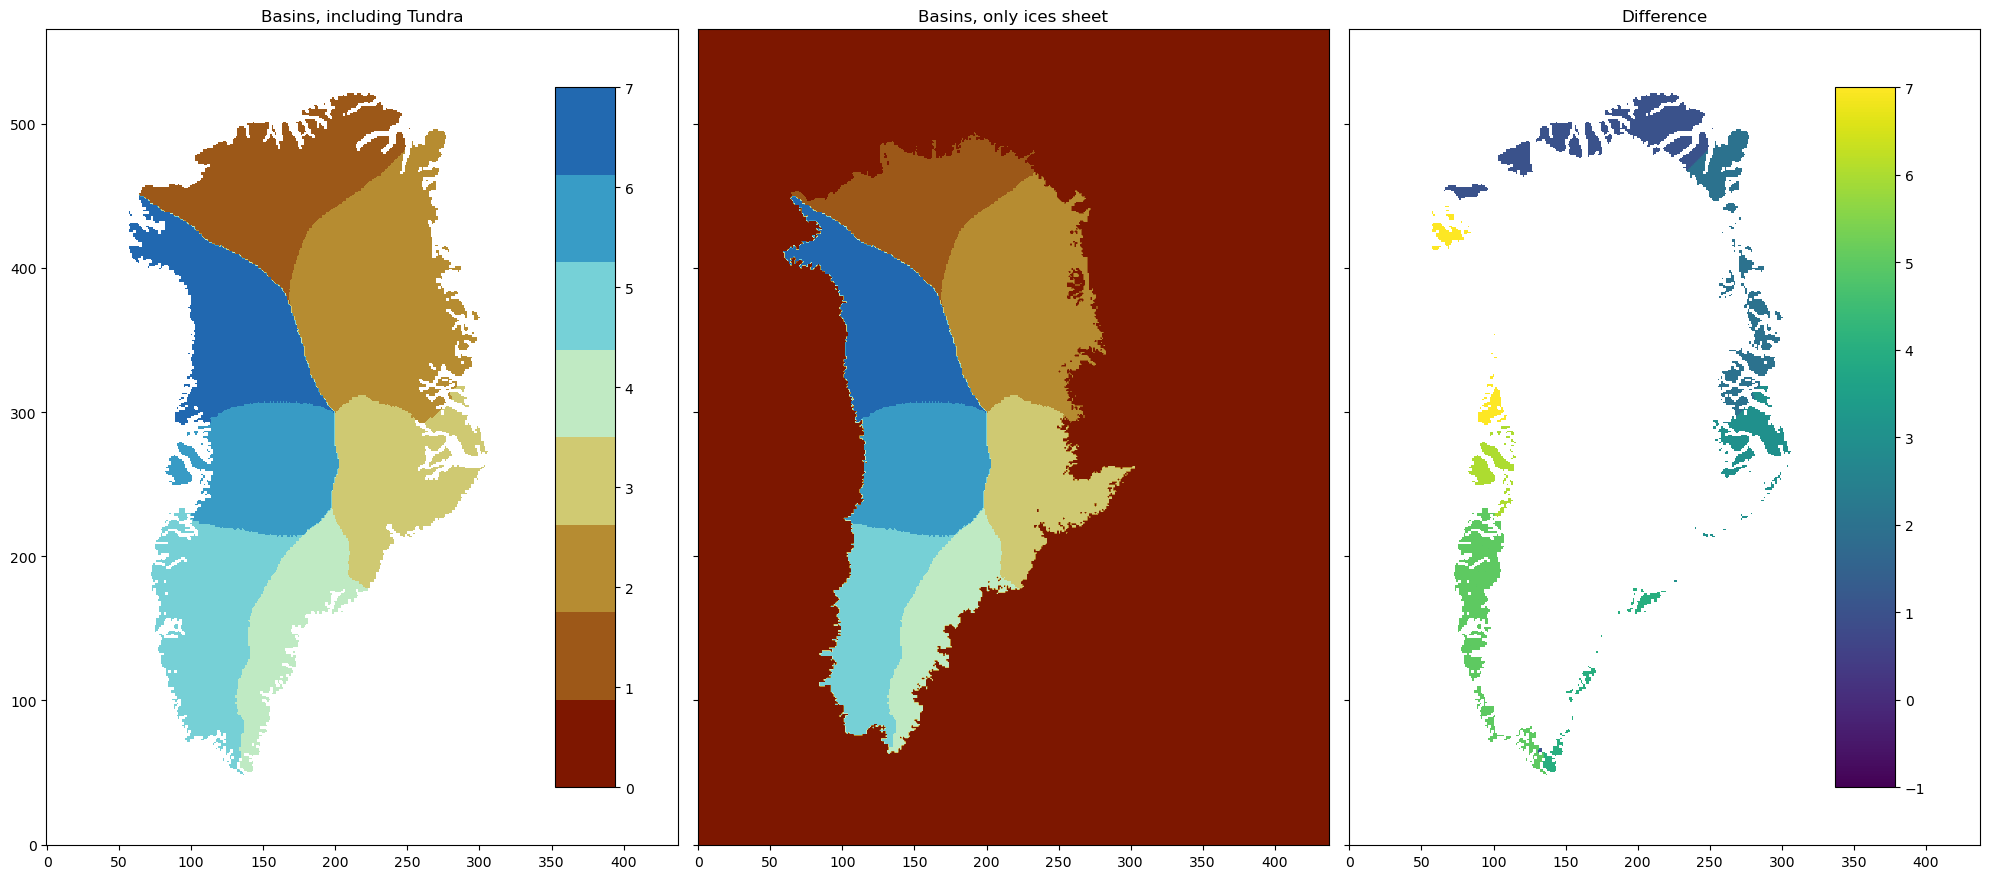

In [97]:
fig, axs = plt.subplots(1,3, sharex=True, sharey=True, figsize=(20,10))

# make shared normed discrete colorbar
norm = mcolors.Normalize(vmin=0, vmax=7)
cmap = mcolors.ListedColormap(colors)

axs[0].imshow(mask_incl_Tundra['Basins'].values, cmap=cmap, norm=norm)
im_basins = axs[1].imshow(ds5_vol['Mouginot_basins'].values, cmap=cmap, norm=norm)

difference = mask_incl_Tundra['Basins'].values - ds5_vol['Mouginot_basins'].values
masked_difference = np.ma.masked_where(difference == 0, difference)
# diff = axs[2].imshow(masked_difference, norm=mcolors.Normalize(vmin=1, vmax=7))
diff = axs[2].imshow(masked_difference)
# give titless to subplots
axs[0].set_title("Basins, including Tundra")
axs[1].set_title("Basins, only ices sheet")
axs[2].set_title("Difference")

cax_basins = fig.add_axes([0.28, 0.15, 0.03, 0.7])
plt.colorbar(im_basins, ax=axs[0], cax=cax_basins)

cax = fig.add_axes([0.92, 0.15, 0.03, 0.7])
plt.colorbar(diff, ax=axs[2], cax=cax)
axs[0].invert_yaxis()
    
plt.tight_layout()

plt.show()


In [ ]:
import numpy as np

# Calculate the difference
difference = mask_incl_Tundra['Basins'].values - ds5_vol['Mouginot_basins'].values

# Mask values that are zero
masked_difference = np.ma.masked_where(difference == 0, difference)

# Plot the masked difference
diff = axs[2].imshow(masked_difference)

# Example masks  for 1 Km

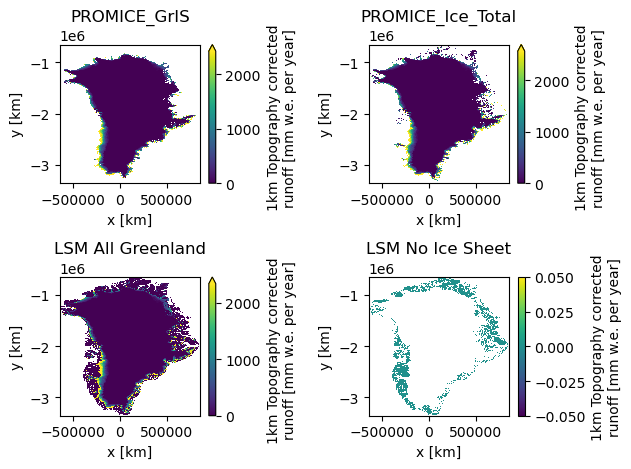

In [ ]:
# make subplots for all masks of 1 k
masks = ["PROMICE_GrIS", "PROMICE_Ice_Total", "LSM All Greenland", "LSM Tundra"]

ds1 = read_RACMO("1k", "Annual",years=["2000", "2020"], variable="runoff")
masks1k = open_mask_1k()
masks1k['Promicemask'] ==3 

fig = plt.subplots(2,2,)
for i, mask in enumerate(masks):
    ds_masked = mask_data_1k(ds1.isel(time=0), mask)
    ax = plt.subplot(2,2,i+1)
    ds_masked['runoffcorr'].plot(ax=ax, robust=True)
    plt.title(mask)
plt.tight_layout()

In [ ]:
ds5_vol

<xarray.DataArray (time: 21, height: 1, rlat: 566, rlon: 438)>
array([[[[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]]],


       [[[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]]],


       [[[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
...
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]]],


       [[[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]]],


       [[[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]]]])
Coordinates:
  * time             (time) datetime64[ns] 2000-07-01T12:00:00 ... 2020-07-01...
  * rlon             (rlon) float64 -10.05 -10.0 -9.95 -9.9 ... 11.7 11.75 11.8
  * rlat             (rlat) float64 -14.4 -14.35 -14.3 ... 13.75 13.8 13.85
  * height           (height) float64 0.0
    Mouginot_basins  (rlat, rlon) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0

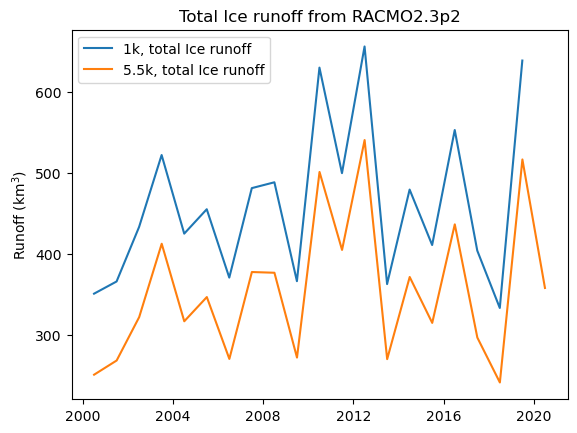

In [ ]:
ds1_vol = volume(ds1["runoffcorr"], "1k").sum(dim=['x', 'y'])
ds1_vol.plot(label="1k, total Ice runoff")
mask_data_5_5k(ds5_vol,"PROMICE_Ice_Total").sum(dim=['rlon', 'rlat']).plot(label="5.5k, total Ice runoff")



plt.ylabel(r"Runoff (km$^3$)")
plt.xlabel("")
plt.title("Total Ice runoff from RACMO2.3p2")
plt.legend()

In [ ]:
path = "/Volumes/imau01/rapid/RACMO2.4/ini_files/FGRN055/vf194009010000.nc"

In [ ]:
!ls -al "/Volumes/imau01/rapid/RACMO2.4/ini_files/FGRN055/vf194009010000.nc"

-rwx------  1 annek  staff  499796820 Dec 12 11:25 /Volumes/imau01/rapid/RACMO2.4/ini_files/FGRN055/vf194009010000.nc


In [ ]:
xr.open_dataset(path)

<xarray.Dataset>
Dimensions:       (time: 1, lon: 2, lat: 2, rlon: 438, rlat: 566, lev: 1,
                   nhyi: 40, nhym: 39, height: 1, height_2: 100)
Coordinates:
  * time          (time) datetime64[ns] 1919-01-01T02:01:00
  * lon           (lon) float64 -0.001 0.0
  * lat           (lat) float64 0.001 0.0
  * rlon          (rlon) float64 -10.05 -10.0 -9.95 -9.9 ... 11.7 11.75 11.8
  * rlat          (rlat) float64 -14.4 -14.35 -14.3 -14.25 ... 13.75 13.8 13.85
  * lev           (lev) float64 6.554e+04
  * height        (height) float64 0.0
  * height_2      (height_2) float64 999.0 998.0 997.0 ... 902.0 901.0 900.0
Dimensions without coordinates: nhyi, nhym
Data variables: (12/15)
    rotated_pole  int32 ...
    hyai          (nhyi) float64 ...
    hybi          (nhyi) float64 ...
    hyam          (nhym) float64 ...
    hybm          (nhym) float64 ...
    var254        (time, lev, lat, lon) float32 ...
    ...            ...
    var84         (time, height, rlat, rlon) float32 ...
    var206        (time, height_2, rlat, rlon) float32 ...
    var67         (time, height_2, rlat, rlon) float32 ...
    var157        (time, height_2, rlat, rlon) float32 ...
    var68         (time, height_2, rlat, rlon) float32 ...
    var154        (time, height_2, rlat, rlon) float32 ...
Attributes:
    CDI:          Climate Data Interface version 2.1.1 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Tue Dec 05 13:58:08 2023: cdo -f nc copy vf194009010000 vf1...
    CDO:          Climate Data Operators version 2.1.1 (https://mpimet.mpg.de...

# Precipitation

In [92]:
from scripts.open_preprocess_racmo import *
# ds1prep = read_RACMO("1k", "Annual",years=["2020", "2022"], variable="precip")

precipitation_annual = "/Volumes/imau01/rapid/RACMO2.3p2/FGRN055/Downscaling_GR/Annual/precip.1958-2023.BN_RACMO2.3p2_ERA5_3h_FGRN055.1km.YY.nc.gz"
ds_precip = xr.open_dataset(precipitation_annual, decode_times=False)
decadal_year = ds_precip['time'].values
ds_precip['time'] = pd.to_datetime(1958+decadal_year, format='%Y') +pd.to_timedelta(decadal_year%1*365, unit='d')




In [94]:
# precipitation_annual = "/Volumes/imau01/rapid/RACMO2.3p2/FGRN055/Downscaling_GR/Annual/precip.1958-2023.BN_RACMO2.3p2_ERA5_3h_FGRN055.1km.YY.nc.gz"
# ds_precip = xr.open_dataset(precipitation_annual, decode_times=False)
# ds_precip['time'] = pd.to_datetime(decadal_year, format='%Y') +pd.to_timedelta(decadal_year%1*365, unit='d')


masks1k = open_mask_1k()
masks1k['x'] = ds_precip['x']
masks1k['y'] = ds_precip['y']
dsPrecipFjords = ds_precip["precipcorr"].where(masks1k["fjords"], np.nan)
# dsPrecipFjords.to_netcdf(pathDataTemp + "RACMO2.3p2_1km_precip_fjords_1958_2020.nc"/)

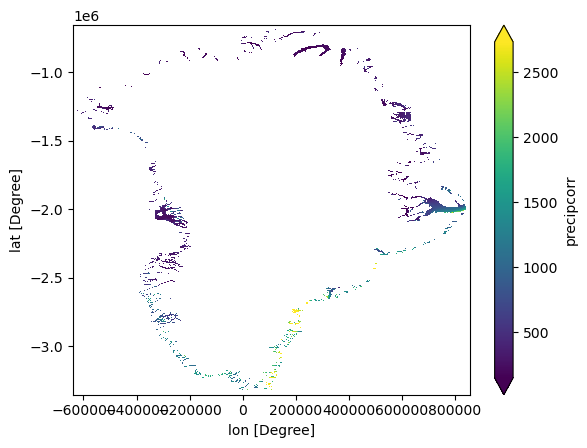

In [95]:
dsPrecipFjords.mean(dim='time').plot(robust=True)

In [96]:
ds_precip_years = xr.open_dataset(precipitation_annual, decode_times=False)

masks1k = open_mask_1k()
masks1k['x'] = ds_precip_years['x']
masks1k['y'] = ds_precip_years['y']
dsPrecipFjords_years = ds_precip_years["precipcorr"].where(masks1k["fjords"], np.nan)
polyfit = ds_precip_years.polyfit(dim='time',deg=1)


In [108]:
dsPrecipFjords_years

<xarray.DataArray 'precipcorr' (time: 66, y: 2700, x: 1496)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]], dtype=float32)
Coordinates:
  * time     (time) float32 0.0 1.0 2.0 3.0 4.0 ... 62.46 63.46 64.46 65.46
  * x        (x) float32 -6.39e+05 -6.38e+05 -6.37e+05 ... 8.55e+05 8.56e+05
  * y        (y) float32 -3.355e+06 -3.354e+06 ... -6.566e+05 -6.556e+05
Attributes:
    standard_name:  Downscaled_precip
    long_name:      Downscaled precip
    units:          mmWE
    actual_range:   [1.2958922e+01 1.4133839e+04]

In [169]:
import scipy.stats as stats
dsPrecipFjords_years_trend = dsPrecipFjords_years.to_dataset(name="Precipitation").stack(z=('x', 'y'))
dsPrecipFjords_years_trend["p_value"] = xr.zeros_like(dsPrecipFjords_years_trend.isel(time=0)['Precipitation'])
dsPrecipFjords_years_trend["slope"] = xr.zeros_like(dsPrecipFjords_years_trend.isel(time=0)['Precipitation'])
dsPrecipFjords_years_trend["R_value"] = xr.zeros_like(dsPrecipFjords_years_trend.isel(time=0)['Precipitation'])
time = dsPrecipFjords_years['time'].values

# stack 
dsPrecipFjords_years_stacked = dsPrecipFjords_years.stack(z=( 'x', 'y'))

arr_precip = dsPrecipFjords_years_stacked.values
nr_loc = np.shape(arr_precip)[1]
# find all that are not nan in the first row
not_nan = np.squeeze(np.where(~np.isnan(arr_precip[0, :])))

# make an empty array like arr_precip[0,:]
arrslope = np.zeros(nr_loc)
arrP = np.zeros(nr_loc)
Rval = np.zeros(nr_loc)

for i in tqdm(not_nan):
    slope, intercept, r_value, p_value, std_err = stats.linregress(time, arr_precip[:, i])
    arrslope[i] = slope
    arrP[i] = p_value
    Rval[i] = r_value
dsPrecipFjords_years_trend["p_value"] = xr.DataArray(arrP, dims=['z'])
dsPrecipFjords_years_trend["slope"] = xr.DataArray(arrslope, dims=['z'])
dsPrecipFjords_years_trend["R_value"] = xr.DataArray(Rval, dims=['z'])
dsPrecipFjords_years_trend = dsPrecipFjords_years_trend.unstack('z')

100%|██████████| 74361/74361 [00:06<00:00, 11187.85it/s]


In [208]:
empty_array = np.zeros_like(dsPrecipFjords_years.isel(time=0).values)
slope_array = empty_array.copy()
p_array = empty_array.copy()

all_precipitation_array = dsPrecipFjords_years.values
x_array = dsPrecipFjords_years["x"]
y_array = dsPrecipFjords_years["y"]

sign_x = []
sign_y = []

for i, x_val in tqdm(enumerate(x_array)):
    for j, y_val in enumerate(y_array):
        if np.isnan(all_precipitation_array[0, j, i]):
            continue
        else:
            slope, intercept, r_value, p_value, std_err = stats.linregress(time, all_precipitation_array[:, j,i])
            slope_array[ j, i] = slope
            p_array[j, i] = p_value
            if (p_value < 0.05)&(p_value > 0):
                sign_x.append(x_val)
                sign_y.append(y_val)


1it [00:00,  6.93it/s]

695it [1:02:39,  5.41s/it] 


KeyboardInterrupt: 

NameError: name 'sign_x' is not defined

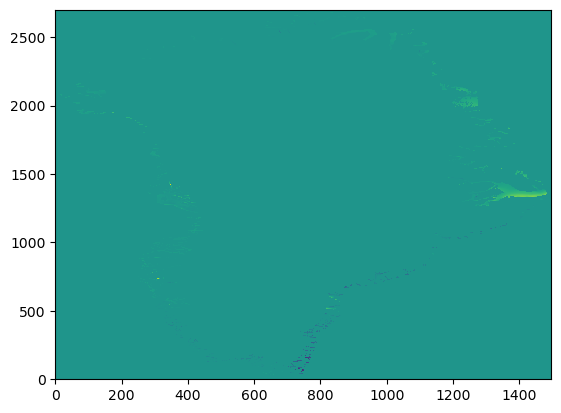

In [ ]:
# plt.pcolormesh(empty_array)
plt.scatter(sign_x, sign_y)

TypeError: 'QuadMesh' object is not subscriptable

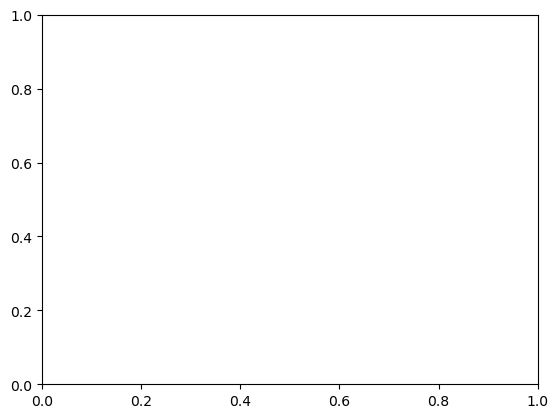

In [196]:
fig, ax = plt.subplots(1,1) 
# dsPrecipFjords_years_trend["slope"].plot(robust=True, ax=ax)
significant = dsPrecipFjords_years_trend.where((dsPrecipFjords_years_trend["p_value"] < 0.05)& (dsPrecipFjords_years_trend["p_value"] > 0.0))
# find values for sy and x where significant has a value
# for every value in significant find it's corresponding x


In [97]:
import scipy.stats

# Assuming dsPrecipFjords_years is a DataArray with a 'time' dimension
x = dsPrecipFjords_years['time']
y = dsPrecipFjords_years

# Perform linear regression
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)

print(f'p-value for the trend: {p_value}')

ValueError: y has more than 2 dimensions

In [83]:
polyfit_fjords = dsPrecipFjords_years.polyfit(dim='time',deg=1)


polyfit_fjords.polyfit_coefficients.sel(degree=1).plot(robust=True)


AttributeError: 'Dataset' object has no attribute 'precipcorr_polyfit_coefficients'

Text(0.5, 1.0, 'mm/year change (1958-2023)')

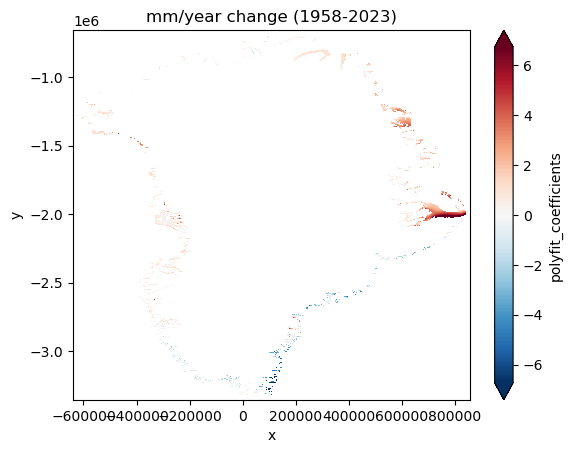

In [87]:
polyfit_fjords.polyfit_coefficients.sel(degree=1).plot(robust=True)
plt.title("mm/year change (1958-2023)")

Text(0.5, 1.0, 'mm/year change (1958-2023)')

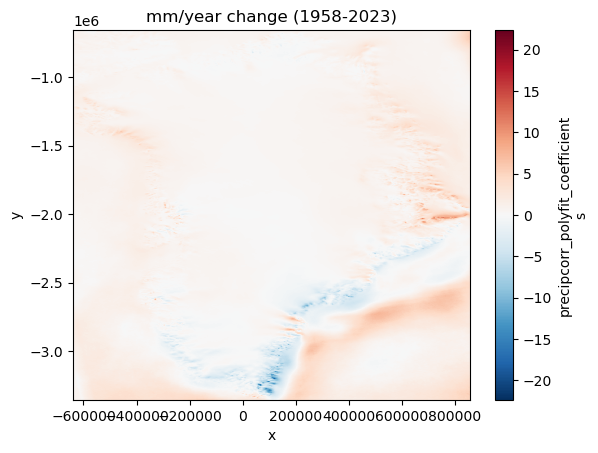

In [ ]:
polyfit.precipcorr_polyfit_coefficients.sel(degree=1).plot(robust=True)
plt.title("mm/year change (1958-2023)")

In [81]:
1958+65


2023

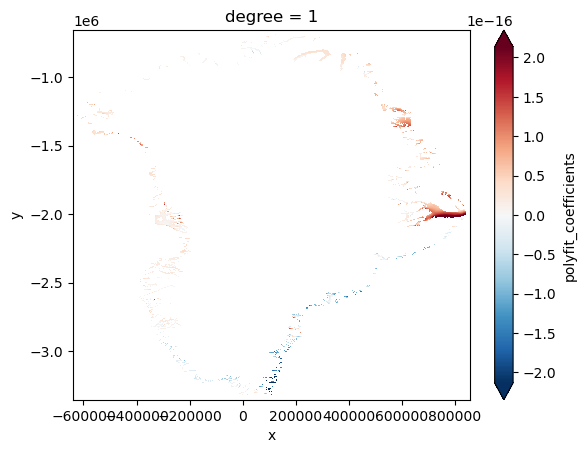

In [ ]:
polyfit.polyfit_coefficients.sel(degree=1).plot(robust=True)

In [ ]:
dsPrecipMonth = read_RACMO("1k", "Monthly",years=["2010", "2021"], variable="precip")
dsMonthlyPrecip = dsMonthlyPrecip.sel(time=slice("2010", "2021"))

 it might be hard to process the data for the whole period, please be patient, or choose a lower time resolution or spatial resolution
/Volumes/imau01/rapid/RACMO2.3p2/FGRN055


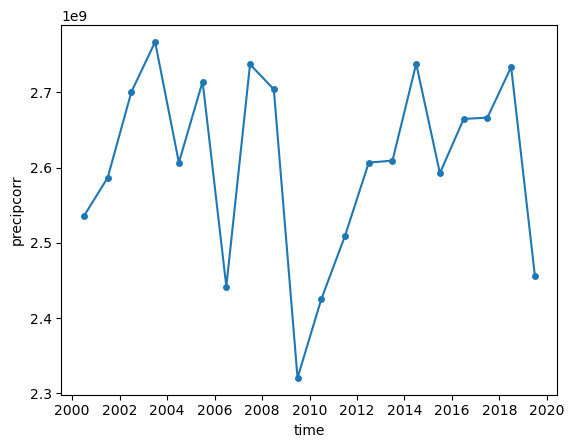

In [ ]:
ds1prep['precipcorr'].sum(dim=['x', 'y']).plot(label="1k")
ds1prep['precipcorr'].sum(dim=['x', 'y']).plot.scatter(label="1k Annual precip")



In [ ]:
ds1snowfrac = xr.open_dataset("/Users/annek/Documents/RACMO2.3p2/FGRN055/Downscaling_GR/Annual/snowfrac.2010-2021.BN_RACMO2.3p2_ERA5_3h_FGRN055.1km.YY.nc")

In [ ]:

dsMonthlySnow = (ds1snowfrac['snowfrac']*dsPrecipMonth['precipcorr']).sum(dim=['x', 'y'])
dsMonthlyPrecip = mask_data_1k(dsPrecipMonth['precipcorr'], "LSM All Greenland").sum(dim=['x', 'y'])

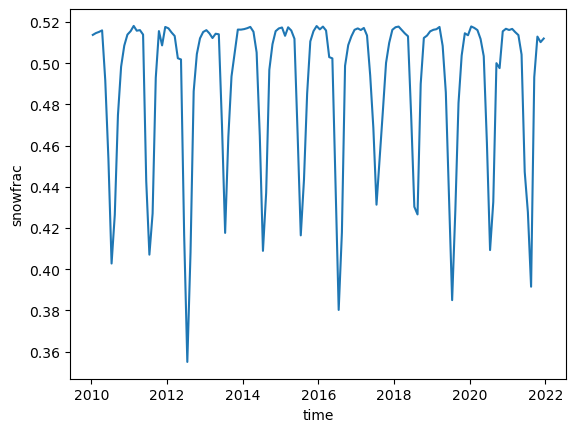

In [ ]:
ds1snowfrac['snowfrac'].mean(dim=['x', 'y']).plot()

In [ ]:
dssnowfrac_mask = mask_data_1k(ds1snowfrac['snowfrac'], "LSM All Greenland")
dsprecip_mask = mask_data_1k(ds1prep['precipcorr'], "LSM All Greenland")

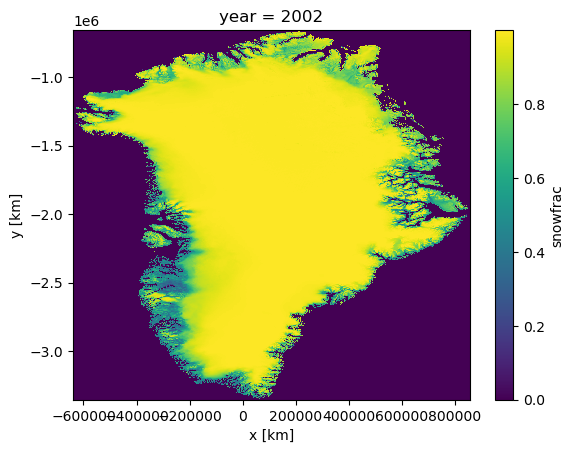

In [ ]:
ds.isel(year=1)['snowfrac'].plot()

In [ ]:
ds =xr.open_dataset("/Users/annek/Documents/RACMO2.3p2/FGRN055/Downscaling_GR/Annual/snowfrac.2000-2021.BN_RACMO2.3p2_ERA5_3h_FGRN055.1km.AN.nc")
ds_tundra = mask_data_1k(ds, "LSM Tundra")
ds = mask_data_1k(ds, "LSM All Greenland")


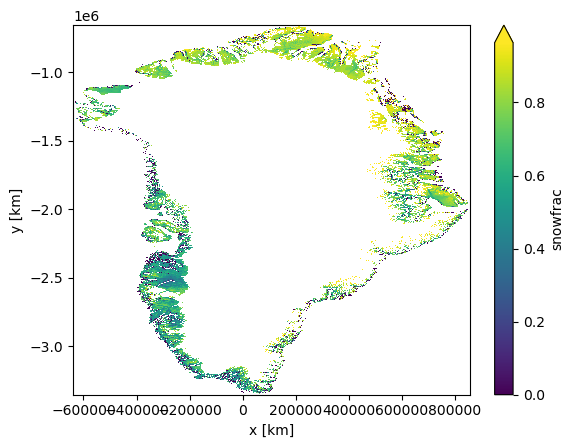

In [ ]:
ds_tundra['snowfrac'].mean(dim='time').plot(robust=True) 

Text(0.5, 0, 'Year')

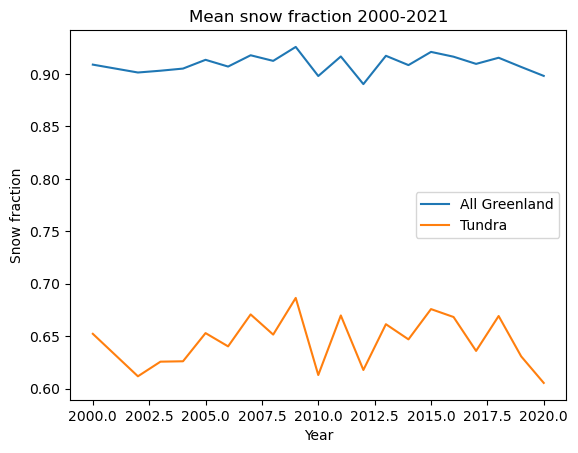

In [ ]:

plt.plot(ds['time'], ds['snowfrac'].mean(dim=['x', 'y']), label="All Greenland")
plt.plot(ds['time'], ds_tundra['snowfrac'].mean(dim=['x', 'y']), label="Tundra")
plt.legend()
plt.title("Mean snow fraction 2000-2021")
plt.ylabel("Snow fraction")
plt.xlabel("Year")
# minor ticks every 1 year and major ticks every 5




In [ ]:
import glob
pathrapid = "/Volumes/imau01/rapid/RACMO2.3p2/FGRN055"
variable = "snowfrac"
time_resolution = "Monthly"
downscaling_type = "Downscaling_GR"
pathmonthly = os.path.join(pathrapid, downscaling_type, time_resolution)
pattern = os.path.join(pathmonthly, "**", "*.[ng]z")
files = glob.glob(pattern, recursive=True)
print(files)

['/Volumes/imau01/rapid/RACMO2.3p2/FGRN055/Downscaling_GR/Monthly/1990/precip.1990.BN_RACMO2.3p2_ERA5_3h_FGRN055.1km.MM.nc.gz', '/Volumes/imau01/rapid/RACMO2.3p2/FGRN055/Downscaling_GR/Monthly/1990/refreeze.1990.BN_RACMO2.3p2_ERA5_3h_FGRN055.1km.MM.nc.gz', '/Volumes/imau01/rapid/RACMO2.3p2/FGRN055/Downscaling_GR/Monthly/1990/runoff.1990.BN_RACMO2.3p2_ERA5_3h_FGRN055.1km.MM.nc.gz', '/Volumes/imau01/rapid/RACMO2.3p2/FGRN055/Downscaling_GR/Monthly/1990/smb_rec.1990.BN_RACMO2.3p2_ERA5_3h_FGRN055.1km.MM.nc.gz', '/Volumes/imau01/rapid/RACMO2.3p2/FGRN055/Downscaling_GR/Monthly/1990/sndiv.1990.BN_RACMO2.3p2_ERA5_3h_FGRN055.1km.MM.nc.gz', '/Volumes/imau01/rapid/RACMO2.3p2/FGRN055/Downscaling_GR/Monthly/1990/snowfall.1990.BN_RACMO2.3p2_ERA5_3h_FGRN055.1km.MM.nc.gz', '/Volumes/imau01/rapid/RACMO2.3p2/FGRN055/Downscaling_GR/Monthly/1990/snowmelt.1990.BN_RACMO2.3p2_ERA5_3h_FGRN055.1km.MM.nc.gz', '/Volumes/imau01/rapid/RACMO2.3p2/FGRN055/Downscaling_GR/Monthly/1990/subl.1990.BN_RACMO2.3p2_ERA5_3h_FG

Text(0.5, 0, '')

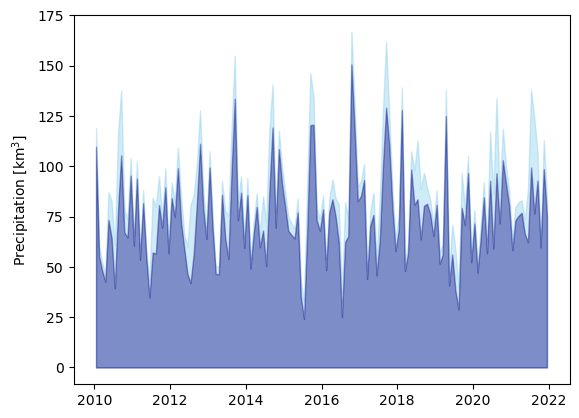

In [ ]:
# make an area plot
dsMonthlyPrecip = dsMonthlyPrecip.sel(time=slice("2010", "2021"))
plt.fill_between(dsMonthlyPrecip.time,0,  dsMonthlyPrecip/1e6, color="skyblue", alpha=0.4)
plt.fill_between(dsMonthlySnow.time, 0, dsMonthlySnow/1e6, color="navy", alpha=0.4)
plt.ylabel(r"Precipitation [km$^3$]")
plt.xlabel("")

In [ ]:
ds1snowfrac['snowfrac'].mean(dim=['x', 'y']).plot(label="1k")

<xarray.Dataset>
Dimensions:   (x: 1496, y: 2700, time: 144)
Coordinates:
  * x         (x) float32 -6.39e+05 -6.38e+05 -6.37e+05 ... 8.55e+05 8.56e+05
  * y         (y) float32 -3.355e+06 -3.354e+06 ... -6.566e+05 -6.556e+05
  * time      (time) datetime64[ns] 2010-01-16 ... 2021-12-16
Data variables:
    snowfrac  (time, y, x) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
Attributes:
    title:        Monthly mean snowfrac field at 1km (RACMO2.3p2 FGRN055 ERA)
    institution:  IMAU (Brice Noel)
    grid:         Map Projection:Polar Stereographic Ellipsoid - Map Referenc...
    history:      libUN (2013.05.22) - Fri Apr 30 23:45:18 2021
    netcdf:       4.7.4 of Apr 18 2020 10:56:44 $

In [ ]:
ds_masked = mask_data_1k(ds1snowfrac.isel(time=0), "LSM Tundra")

In [8]:
masks1k_fjord = xr.open_dataset("/Users/annek/Documents/RACMO2.3p2/FGRN055/Downscaling_GR/masks1k.nc")

In [113]:
masks1k = open_mask_1k()
masks55k = open_mask_5_5k()

In [11]:
masks1k['fjords'] = masks1k_fjord['fjords']

In [114]:
masks1k

<xarray.Dataset>
Dimensions:           (time: 1, x: 1496, y: 2700)
Coordinates:
  * time              (time) float32 0.0
  * x                 (x) float32 5.0 10.0 15.0 ... 7.47e+03 7.475e+03 7.48e+03
  * y                 (y) float32 5.0 10.0 15.0 ... 1.349e+04 1.35e+04 1.35e+04
Data variables: (12/14)
    LON               (y, x) float32 ...
    LAT               (y, x) float32 ...
    Icemask           (y, x) float32 ...
    Promicemask       (y, x) float32 ...
    Topography        (y, x) float32 0.0 0.0 0.0 ... 9.999e+03 9.999e+03
    GrIS              (y, x) float32 ...
    ...                ...
    Easting           (y, x) float32 ...
    Northing          (y, x) float32 ...
    LSM               (y, x) int64 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
    LSM_no_islands    (y, x) int64 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
    LSM_Qeqertarsuaq  (y, x) int64 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
    fjords            (y, x) int64 ...
Attributes:
    title:                      Daily Surface mass balance field (RACMO2.3)
    institution:                ULg (Xavier Fettweis)
    grid:                       Map Projection:Polar Stereographic Ellipsoid ...
    history:                    Mon Aug 10 13:33:00 2020: ncks -v Easting,Nor...
    netcdf:                     4.3.2 of Jan  5 2015 11:27:10 $
    NCO:                        netCDF Operators version 4.8.0 (Homepage = ht...
    history_of_appended_files:  Mon Aug 10 13:33:00 2020: Appended file GIMP_...

In [116]:
masks55k

<xarray.Dataset>
Dimensions:          (rlat: 566, rlon: 438, time: 1)
Coordinates:
  * time             (time) datetime64[ns] 1957-09-01
  * rlon             (rlon) float32 0.0 1.0 2.0 3.0 ... 434.0 435.0 436.0 437.0
  * rlat             (rlat) float32 0.0 1.0 2.0 3.0 ... 562.0 563.0 564.0 565.0
Data variables: (12/18)
    Icemask_noGR     (rlat, rlon) float32 ...
    Icemask_GR       (rlat, rlon) float32 ...
    X                (rlat, rlon) float32 ...
    Y                (rlat, rlon) float32 ...
    lon              (rlat, rlon) float32 ...
    lat              (rlat, rlon) float32 ...
    ...               ...
    Promicemask      (rlat, rlon) float32 ...
    GRACE_basins     (rlat, rlon) float32 ...
    Mouginot_basins  (rlat, rlon) float32 ...
    LSM_GR           (rlat, rlon) float32 ...
    Grounded_ice     (rlat, rlon) float32 ...
    Basins           (rlat, rlon) float32 ...
Attributes:
    title:                      FGRN055 Masks
    institution:                IMAU (Brice Noel)
    grid:                       Map Projection:Polar Stereographic Ellipsoid ...
    history:                    Wed Nov  7 14:41:41 2018: ncks -A -v Basins i...
    netcdf:                     4.4.1.1 of Nov 25 2017 10:57:26 $
    history_of_appended_files:  Wed Nov  7 14:41:41 2018: Appended file in/Ic...
    NCO:                        4.6.6
    nco_openmp_thread_number:   1

# 500 m Downscaled

In [8]:
folder500m = "/Volumes/imau02/rapid/Anneke/RACMO2.3p2/FGRN055/Downscaling_GR_500m/"

fileRACMO = folder500m + "Annual/runoff.1940-2023.BN_RACMO2.3p2_ERA5_3h_1940_FGRN055.GrIS.0.5km.YY.nc"
mask_500m = folder500m + "GrIS_topo_icemask_lsm_lon_lat_0.5km.nc"
fileMAR = folder500m + "Annual/runoff.1940-2023.MAR3v14.GrIS.0.5km.YY.nc"

file_1km = "/Volumes/imau01/rapid/RACMO2.3p2/FGRN055/Downscaling_GR/Annual/runoff.1958-2023.BN_RACMO2.3p2_ERA5_3h_FGRN055.1km.YY.nc.gz"
file_5_5km = "/Volumes/imau01/rapid/RACMO2.3p2/FGRN055/BN_RACMO2.3p2_ERA5_3h_FGRN055/Annual/runoff_yearlyS_FGRN055_BN_RACMO2.3p2_ERA5_3h_1940_FGRN055_1940_1950.nc"


In [10]:
ds_500m = xr.open_dataset(fileRACMO)
mask_500m = xr.open_dataset(mask_500m)



In [17]:
pathlocal

'/Users/annek/Documents/RACMO2.3p2/FGRN055/'

In [19]:
mask_500m['Tundra'] = (mask_500m['LSM']- mask_500m['Promicemask'].where(mask_500m['Promicemask']==0, 1))
# give it a description: 0 = not Tundra, 1 = Tundra, calculated as LSM (where there is land) - Promicemask (where there is ice)
mask_500m['Tundra'].attrs['description'] = "0 = not Tundra, 1 = Tundra, calculated as LSM (where there is land) - Promicemask (where there is ice)"
# write to netcdf
# mask_500m.to_netcdf(folder500m + "GrIS_topo_icemask_lsm_lon_lat_0.5km.nc")
mask_500m.to_netcdf(pathlocal + "GrIS_topo_icemask_lsm_lon_lat_tundra_0.5km.nc")

RuntimeError: NetCDF: HDF error

In [7]:
mask_500m['Tundra'].plot.pcolormesh(figsize=(12,12))

TypeError: string indices must be integers, not 'str'

In [12]:
Area5_5 = open_mask_5_5k().Area

In [22]:
ds500mMAR = xr.open_dataset(fileMAR)

In [10]:
ds_1km = xr.open_dataset(file_1km, decode_times=False)
ds_5_5km = xr.open_dataset(file_5_5km)


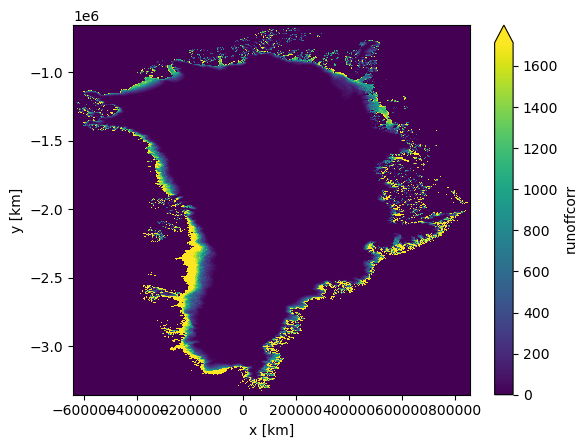

In [8]:
ds_500m.runoffcorr.mean(dim='time').plot(robust=True)

In [15]:
if os.path.exists(folder500m + "Annual/sum/runoff_yearly_sum.1940-2023.BN_RACMO2.3p2_ERA5_3h_1940_FGRN055.GrIS.0.5km.YY.nc"):
    ds_500m_sum = xr.open_dataset(folder500m + "Annual/sum/runoff_yearly_sum.1940-2023.BN_RACMO2.3p2_ERA5_3h_1940_FGRN055.GrIS.0.5km.YY.nc")
else:
    ds_500m_sum = ds_500m.runoffcorr.sum(dim=['x', 'y'])/4
    
if os.path.exists(folder500m + "Annual/sum/runoff_yearly_sum.1940-2023.MAR3v14.GrIS.0.5km.YY.nc"):
    ds500mMAR_sum = xr.open_dataset(folder500m + "Annual/sum/runoff_yearly_sum.1940-2023.MAR3v14.GrIS.0.5km.YY.nc")
else:
    ds500mMAR_sum = ds500mMAR.runoffcorr.sum(dim=['x', 'y'])

ds_1km_sum = ds_1km.runoffcorr.sum(dim=['x', 'y'])


AttributeError: 'Dataset' object has no attribute 'runoff'

In [17]:
ds500mMAR_sum = ds500mMAR.runoffcorr.sum(dim=['x', 'y'])/4


In [49]:
ds_5_5km_sum =( ds_5_5km.runoff * Area5_5).sum(dim=['rlon', 'rlat'])

/var/folders/cv/s_h5gzxd0h71t_d875wqxgzh0000gn/T/ipykernel_68687/1369296324.py:4: FutureWarning: 'AS' is deprecated and will be removed in a future version, please use 'YS' instead.
  ds_1km_sum['time'] =pd.date_range(start='1958-01-01', periods=len(ds_1km['time']), freq='AS')


Text(0, 0.5, 'Runoff (km$^3$)')

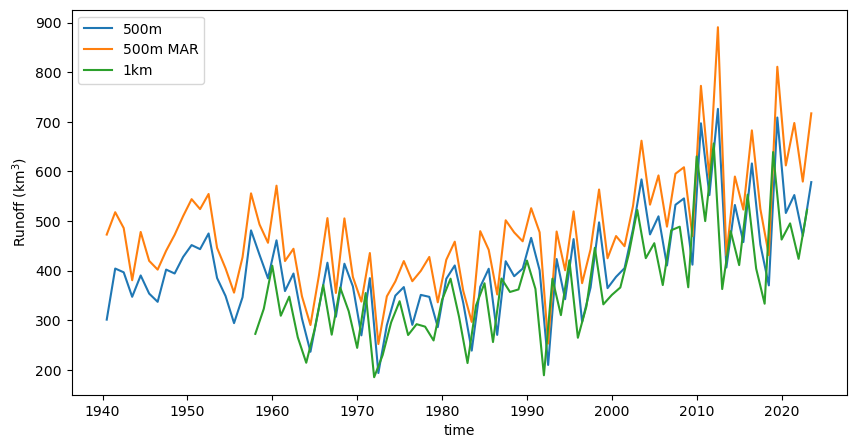

In [20]:
fig, axs = plt.subplots(1,1, figsize=(10,5))
(ds_500m_sum/1e6).plot(ax= axs, label="500m")
(ds500mMAR_sum/1e6).plot(ax=axs, label="500m MAR")
ds_1km_sum['time'] =pd.date_range(start='1958-01-01', periods=len(ds_1km['time']), freq='AS')
(ds_1km_sum/1e6).plot(ax=axs, label="1km")

plt.legend()
plt.ylabel(r"Runoff (km$^3$)")

# RUNOFF MAR

In [4]:


path_sums_masks_500m  = "/Volumes/imau02/rapid/Anneke/RACMO2.3p2/FGRN055/Downscaling_GR_500m/Annual/Sums and masks/"

file_paths = {
    "dsRunoff500mRACMO_GIC": path_sums_masks_500m + "runoff.1940-2023.BN_RACMO2.3p2_ERA5_3h_1940_FGRN055.GrIS.0.5km.GIC.YY.nc",
    "dsRunoff500mRACMO_GrIS": path_sums_masks_500m + "runoff.1940-2023.BN_RACMO2.3p2_ERA5_3h_1940_FGRN055.GrIS.0.5km.GrIS.YY.nc",
    "dsRunoff500mRACMO_GIC_sum": path_sums_masks_500m + "runoff_yearly_sum.1940-2023.BN_RACMO2.3p2_ERA5_3h_1940_FGRN055.GrIS.0.5km.GIC.YY.nc",
    "dsRunoff500mRACMO_GrIS_sum": path_sums_masks_500m + "runoff_yearly_sum.1940-2023.BN_RACMO2.3p2_ERA5_3h_1940_FGRN055.GrIS.0.5km.GrIS.YY.nc"
}
datasets_RACMO_runoff_500m = {}

for name, file_path in file_paths.items():
    if os.path.exists(file_path):
        datasets_RACMO_runoff_500m[name] = xr.open_dataset(file_path)
        print(f"Opened {file_path}")

dsRunoff500mRACMO_GIC_sum = datasets_RACMO_runoff_500m["dsRunoff500mRACMO_GIC_sum"]/1e6
dsRunoff500mRACMO_GrIS_sum = datasets_RACMO_runoff_500m["dsRunoff500mRACMO_GrIS_sum"]/1e6
dsRunoff500mRACMO_GIC = datasets_RACMO_runoff_500m["dsRunoff500mRACMO_GIC"]
dsRunoff500mRACMO_GrIS = datasets_RACMO_runoff_500m["dsRunoff500mRACMO_GrIS"]


fpaths_MAR = {
    "dsRunoff500mMAR_GIC": path_sums_masks_500m + "runoff.1940-2023.MAR3v14.GrIS.0.5km.GIC.YY.nc",
    "dsRunoff500mMAR_GrIS": path_sums_masks_500m + "runoff.1940-2023.MAR3v14.GrIS.0.5km.GrIS.YY.nc",
    "dsRunoff500mMAR_GIC_sum": path_sums_masks_500m + "runoff_yearly_sum.1940-2023.MAR3v14.GrIS.0.5km.GIC.YY.nc",
    "dsRunoff500mMAR_GrIS_sum": path_sums_masks_500m + "runoff_yearly_sum.1940-2023.MAR3v14.GrIS.0.5km.GrIS.YY.nc"
}

datasets_MAR_runoff_500m = {}

for name, file_path in fpaths_MAR.items():
    if os.path.exists(file_path):
        datasets_MAR_runoff_500m[name] = xr.open_dataset(file_path)
        print(f"Opened {file_path}")
dsRunoff500mMAR_GIC_sum = datasets_MAR_runoff_500m["dsRunoff500mMAR_GIC_sum"]/1e6
dsRunoff500mMAR_GrIS_sum = datasets_MAR_runoff_500m["dsRunoff500mMAR_GrIS_sum"]/1e6
dsRunoff500mMAR_GIC = datasets_MAR_runoff_500m["dsRunoff500mMAR_GIC"]
dsRunoff500mMAR_GrIS = datasets_MAR_runoff_500m["dsRunoff500mMAR_GrIS"]

for  dataset in [dsRunoff500mRACMO_GIC_sum, dsRunoff500mRACMO_GrIS_sum, dsRunoff500mMAR_GIC_sum, dsRunoff500mMAR_GrIS_sum]:
    dataset.attrs['units'] = 'km3 w.e.'
    # for variable in dataset
    for variable in dataset.variables:
        # if 'units' in dataset[variable].attrs:
        # if dtype is float
        if 'units' in dataset[variable].attrs:
                dataset[variable].values = dataset[variable].values/1e6


    # dataset.values = dataset.values/1e6

OSError: [Errno -101] NetCDF: HDF error: '/Volumes/imau02/rapid/Anneke/RACMO2.3p2/FGRN055/Downscaling_GR_500m/Annual/Sums and masks/runoff.1940-2023.BN_RACMO2.3p2_ERA5_3h_1940_FGRN055.GrIS.0.5km.GIC.YY.nc'

In [ ]:
mask_0_5km =  xr.open_dataset('sections_500m_compressed.nc')

In [ ]:
dsRunoff500mMAR_GIC['section_numbers_adjusted'] = dsRunoff500mMAR_GIC.isel(time=0)['runoffcorr'].copy().drop_vars('time')
dsRunoff500mMAR_GIC['section_numbers_adjusted'].values = np.squeeze(mask_0_5km['section_numbers_adjusted'].values)

dsRunoff500mMAR_GIC['runoffcorr'].groupby(dsRunoff500mMAR_GIC['section_numbers_adjusted']).sum().to_netcdf(path_sums_masks_500m + "runoff.1940-2023.MAR3v14.GIC.0.5km.GIC.YY.per_section.nc")




In [ ]:
dsRunoff500mMAR_GrIS['section_numbers_adjusted'] = dsRunoff500mMAR_GrIS.isel(time=0)['runoffcorr'].copy().drop_vars('time')
dsRunoff500mMAR_GrIS['section_numbers_adjusted'].values = np.squeeze(mask_0_5km['section_numbers_adjusted'].values)


dsRunoff500mMAR_GrIS_per_section = dsRunoff500mMAR_GrIS['runoffcorr'].groupby(dsRunoff500mMAR_GrIS['section_numbers_adjusted']).sum()
print("summed")
dsRunoff500mMAR_GrIS_per_section.to_netcdf(path_sums_masks_500m+ "runoff.1940-2023.MAR3v14.GrIS.0.5km.GrIS.YY.per_section.nc",  encoding={'section_numbers_adjusted': {'zlib': True, 'complevel': 5}})

## 500m RACMO per section

In [6]:
# Calculate dsRunoff500mRACMO_GrIS_per_section

dsRunoff500mRACMO_GrIS['section_numbers_adjusted'] = dsRunoff500mRACMO_GrIS.isel(time=0)['runoffcorr'].copy().drop_vars('time')
dsRunoff500mRACMO_GrIS['section_numbers_adjusted'].values = np.squeeze(mask_0_5km['section_numbers_adjusted'].values)

dsRunoff500mRACMO_GrIS_per_section = dsRunoff500mRACMO_GrIS['runoffcorr'].groupby(dsRunoff500mRACMO_GrIS['section_numbers_adjusted']).sum()
print("summed")
dsRunoff500mRACMO_GrIS_per_section.to_netcdf(  "runoff.1940-2023.BN_RACMO2.3p2_ERA5_3h_1940_FGRN055.GrIS.0.5km.GrIS.YY.per_section.nc",  encoding={'section_numbers_adjusted': {'zlib': True, 'complevel': 5}})
print("saved")

: 

: 

In [ ]:
# Calculate dsRunoff500mRACMO_GIC_per_section

dsRunoff500mRACMO_GIC['section_numbers_adjusted'] = dsRunoff500mRACMO_GIC.isel(time=0)['runoffcorr'].copy().drop_vars('time')
dsRunoff500mRACMO_GIC['section_numbers_adjusted'].values = np.squeeze(mask_0_5km['section_numbers_adjusted'].values)

dsRunoff500mRACMO_GIC_per_section = dsRunoff500mRACMO_GIC['runoffcorr'].groupby(dsRunoff500mRACMO_GIC['section_numbers_adjusted']).sum()
print("summed")
dsRunoff500mRACMO_GIC_per_section.to_netcdf("runoff.1940-2023.BN_RACMO2.3p2_ERA5_3h_1940_FGRN055.GrIS.0.5km.GIC.YY.per_section.nc",  encoding={'section_numbers_adjusted': {'zlib': True, 'complevel': 5}})
print("saved")
